In [34]:
import os
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from utils import make_beta_schedule
from tqdm import trange

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.pyplot.rcParams.update({
    "pgf.preamble": [
         "\\usepackage{arev}",
        "\\usepackage[T1]{fontenc}"]
})


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f'device is {device}')

device is cpu


size of the training set is 500


TypeError: expected np.ndarray (got Tensor)

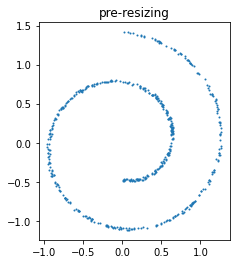

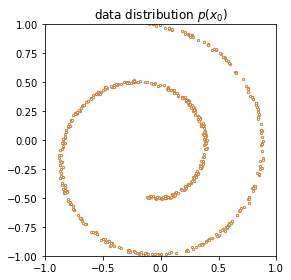

In [35]:
# ---------------------------------------------------------------------------- #
#                            plot the dataset                                  #
# ---------------------------------------------------------------------------- #
from generate_data import load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, make_nd_dataset
from rad_utils import generate_2d_swiss_roll

num_samples = 500
lims = [-1.5, 1.5]

# 2d swiss roll data 
data_2d = load_unimodal_data(num_samples, manifold_type='swiss_roll')
data_2d = torch.from_numpy(data_2d)
_, data_2d, _, _ = generate_2d_swiss_roll(num_samples)
fig, ax = plt.subplots(1, 1)
ax.scatter(*data_2d.T, s=1)
ax.set_aspect('equal')
lims=[-1.5, 1.5]
ax.set(xlim=lims, ylim=lims)

In [36]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #
from rad_utils import select_model

model, num_steps, embedding_dims = select_model('unconditional-concat', 9)

embedding dimension is 2
model loaded!
the model has 34050 parameters


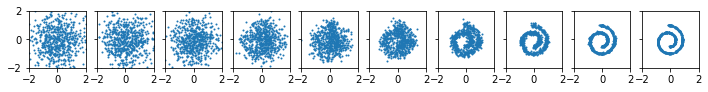

In [37]:
# ------------------- plot samples from the reverse process ------------------ #
from rad_utils import plot_reverse_samples_10_steps

alphas, betas, one_minus_alphas_prod_sqrt, x_seq = plot_reverse_samples_10_steps(model, num_samples, embedding_dims, num_steps)

## anti-diffusion trajectory

Text(0.5, 1.0, 'Trajectory of $\\mathbf{x}_t$')

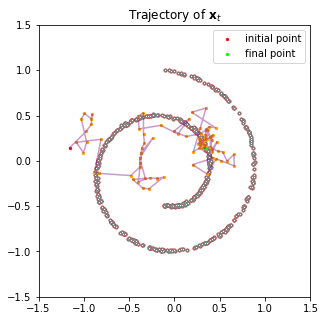

In [38]:
# ---- plot the trajectory of a sample as it undergoes the reverse (anti-diffusion) process --- #
from generate_data import p_sample_loop

# gather reverse trajectory data
x_traj = p_sample_loop(model, (1,2), num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
x_traj = torch.stack(x_traj).detach().cpu()

fig, ax = plt.subplots(1,1, figsize=(5,5))

# plot the underlying distribution
ax.scatter(data_2d[:, 0], data_2d[:, 1], c='firebrick', marker='.')
ax.scatter(data_2d[:,0], data_2d[:,1], color='white', edgecolor='grey', s=5)

# plot all the samples of x_t
for t in range(num_steps, 0, -1):
    ax.scatter(x_traj[t,0,0].detach().cpu(), x_traj[t,0,1].detach().cpu(), color='orange', s=5)

# plot the lines in between
ax.plot(x_traj[:,0,0].detach().cpu(), x_traj[:,0,1].detach().cpu(), '-', color='purple', alpha=0.4)

# plot the first and last points
ax.scatter(x_traj[0,0,0].detach().cpu(), x_traj[0,0,1].detach().cpu(), color='red', s=5, label="initial point")
ax.scatter(x_traj[num_steps,0,0].detach().cpu(), x_traj[num_steps,0,1].detach().cpu(), color='lime', s=5, label='final point')

# add figure details
ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)
ax.legend()
ax.set_title('Trajectory of $\mathbf{x}_t$')

## reversed anti-diffusion

What if we started from the manifold and did the reverse process, but in the reverse order? i.e. reversed the reverse process (instead of doing the forward process)

In [39]:
# first define the reverse anti-diffusion function
# from generate_data import p_sample

from utils import extract
@torch.no_grad()
def p_sample_rev(model, x, t, n_steps, alphas, betas, one_minus_alphas_prod_sqrt, device):
    """
    returns one step of the reversed anti-diffusion process (i.e. the results at one temperature)
    """
    t = torch.tensor([t], device=device)
    
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_prod_sqrt, t, x))
    
    # Model output
    T = t.repeat(x.shape[0], 1) / n_steps
    eps_theta = model(x, T)
    
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    
    # Generate z
    z = torch.randn_like(x, device=device)
    
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return sample, mean

@torch.no_grad()
def p_rev_loop(model, x_0, shape, n_steps, alphas, betas, one_minus_alphas_prod_sqrt, device):
    """
    for each initial datapoint, this function returns the datapoints corresponding to every step of the reversed anti-diffusion process
    """
    cur_x = x_0
    x_seq = [cur_x]
    mean_seq = [cur_x]

    for i in range(n_steps):
        cur_x, cur_mean = p_sample_rev(model, cur_x, i, n_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
        x_seq.append(cur_x)
        mean_seq.append(cur_mean)
    return x_seq, mean_seq

Text(0.5, 1.0, 'Trajectory of reversed anti-diffusion')

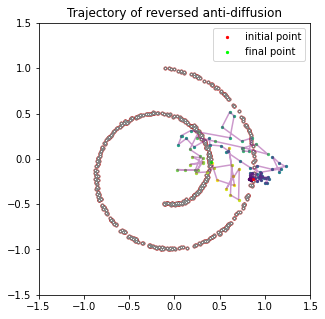

In [40]:
# the reversed anti-diffusion trajectory for one datapoint

# x_init = x_traj[-1, :, :]
num_samples = 500
x_init = data_2d[np.random.randint(num_samples), :].reshape(1, -1)  # we choose one point on the manifold as our initial datapoint
x_rad, _ = p_rev_loop(model, x_init, (1, 2), num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
x_rad = torch.stack(x_rad).detach().cpu()

# plot the underlying distribution
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(data_2d[:, 0], data_2d[:, 1], c='firebrick', marker='.')
ax.scatter(data_2d[:,0], data_2d[:,1], color='white', edgecolor='grey', s=5)

# plot the lines in between
ax.plot(x_rad[:,0,0], x_rad[:,0,1], '-', color='purple', alpha=0.4)


# plot all the samples of x_t_rev
cmap = plt.cm.viridis
for t in range(num_steps, 0, -1):
    color = cmap(t/num_steps)
    ax.scatter(x_rad[t,0,0], x_rad[t,0,1], color=color, s=5)


# plot the first and last points
ax.scatter(x_rad[0,0,0], x_rad[0,0,1], color='red', s=5, label="initial point")
ax.scatter(x_rad[num_steps,0,0], x_rad[num_steps,0,1], color='lime', s=5, label="final point")

# add figure details
ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)
ax.legend()
ax.set_title('Trajectory of reversed anti-diffusion')

## distribution of final points after reversed anti-diffusion
We use the points on the manifold as the initial points for the reversed anti-diffusion process (like we do for the diffusion process). 


torch.Size([1000, 1, 2])


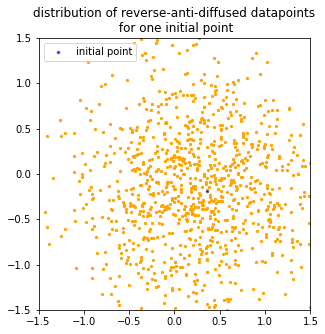

In [41]:
# distribution of final datapoints given one initial datapoint (i.e. the results of running the RAD process many times)

x_init = data_2d[np.random.randint(500), :].view(1, -1)
dist_rad = []
for j in range(1000):
    x_rad, _ = p_rev_loop(model, x_init, x_init.shape, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
    x_rad = x_rad[-1]
    dist_rad.append(x_rad)
dist_rad = torch.stack(dist_rad).detach().cpu()

print(dist_rad.shape)

# plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(dist_rad[:, :, 0], dist_rad[:, :, 1], color='orange', s=5)

# plot the initial point
ax.scatter(x_init[:, 0], x_init[:, 1], color='blue', edgecolor='grey', s=7, label="initial point")

# set figure details
ax.legend()
ax.set_title("distribution of reverse-anti-diffused datapoints\n for one initial point")
ax.set(xlim=lims, ylim=lims)
ax.set_aspect('equal')


[(-1.5, 1.5), (-1.5, 1.5)]

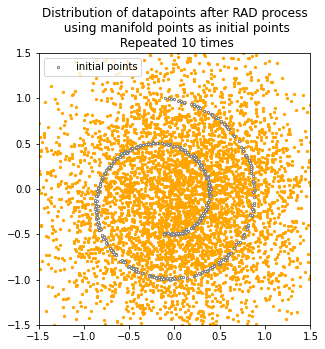

In [42]:
# distribution of final points post reverse anti-diffusion, across all initial points, repeated multiple times. 
# plot the distribution of points post reversed anti-diffusion
fig, ax = plt.subplots(1,1, figsize=(5,5))

x_init = data_2d
for j in range(10):
    x_rad, _ = p_rev_loop(model, x_init, x_init.shape, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
    x_rad = torch.stack(x_rad).detach().cpu()
    ax.scatter(x_rad[-1,:,0], x_rad[-1,:,1], color='orange', s=5)

# plot the underlying distribution
ax.scatter(data_2d[:,0], data_2d[:,1], color='white', edgecolor='grey', s=5, label="initial points")

# add figure details
ax.set_title('Distribution of datapoints after RAD process\n using manifold points as initial points\n Repeated 10 times')
ax.legend()
ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)

## What does the distribution look like at different temperatures?

the total number of steps (num_steps, or T) is 100


/var/folders/p6/byyhchg563x1dl2qn7_ly14r0000gn/T/ipykernel_65855/521029589.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_2d = torch.tensor(data_2d, dtype=torch.float)


torch.Size([1000, 2])


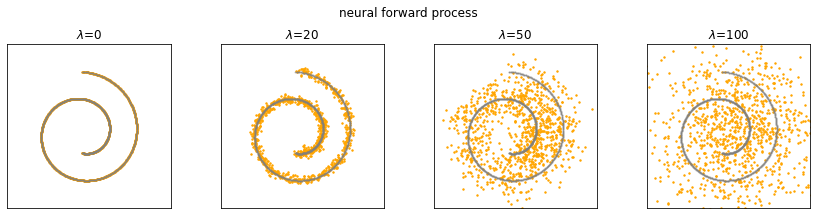

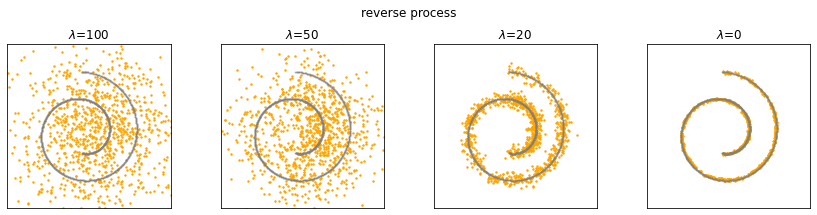

In [43]:
from rad_utils import remove_all_ticks_and_labels

print(f'the total number of steps (num_steps, or T) is {num_steps}')

# -------------------------- neural forward process -------------------------- #
temps = [0, 20, 50, 100]
fig, ax = plt.subplots(1, len(temps), figsize=(12,3), sharey=True)
num_samples = 1000
data_2d = torch.from_numpy(generate_2d_swiss_roll(num_samples)[1])
data_2d = torch.tensor(data_2d, dtype=torch.float)

x_init = data_2d
idx = 0
x_rad, _ = p_rev_loop(model, x_init, x_init.shape, 100, alphas, betas, one_minus_alphas_prod_sqrt, device)
x_rad = torch.stack(x_rad).detach().cpu()
for t in temps:

    ax[idx].scatter(x_rad[t,:,0], x_rad[t,:,1], color='orange', s=2)
    
    # plot the underlying distribution
    ax[idx].scatter(data_2d[:,0], data_2d[:,1], color='grey', alpha=0.4, s=1, label="initial points")
    
    # plot details
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    # ax[idx].legend()
    ax[idx].set_title(f'$\lambda$={t}')
    
    ax[idx].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax[idx].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    
    idx += 1

# add figure details
fig.suptitle(f'neural forward process')
fig.tight_layout()


save = True
if save==True:
    savedir = 'plots/neurips'
    figname = f'neural_forward_process.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)


# -------- reverse process using the last points as its initial points ------- #
temps = [100-t for t in temps]
x_init = x_rad[-1]
x_ad = p_sample_loop(model, x_init.shape, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device, init_x=x_init)
print(x_ad[-1].shape)
fig, ax = plt.subplots(1, len(temps), figsize=(12,3))
idx = 0
for t in reversed(temps):
    ax[idx].scatter(*x_ad[t].T, color='orange', s=2)
    ax[idx].scatter(*data_2d.T, color='grey', alpha=0.4, s=1, label="initial points")
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    ax[idx].set_title(f'$\lambda$={100-t}')
    remove_all_ticks_and_labels(ax[idx])
    idx += 1
    
fig.suptitle(f'reverse process')
fig.tight_layout()

save = True
if save==True:
    savedir = 'plots/neurips'
    figname = f'neural_reverse_process.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

the total number of steps (num_steps, or T) is 100


/var/folders/p6/byyhchg563x1dl2qn7_ly14r0000gn/T/ipykernel_65855/3883252762.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_2d = torch.tensor(data_2d, dtype=torch.float)


torch.Size([1000, 2])


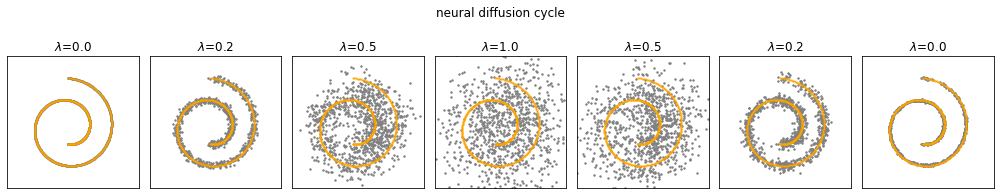

In [45]:
# --------------- just create the whole figure here god dammit --------------- #
from rad_utils import remove_all_ticks_and_labels

print(f'the total number of steps (num_steps, or T) is {num_steps}')

# -------------------------- neural forward process -------------------------- #
temps = [0, 20, 50, 100]
fig, ax = plt.subplots(1, 2*len(temps)-1, figsize=(14,3), sharey=True)
num_samples = 1000
data_2d = torch.from_numpy(generate_2d_swiss_roll(num_samples)[1])
data_2d = torch.tensor(data_2d, dtype=torch.float)

x_init = data_2d
idx = 0
x_rad, _ = p_rev_loop(model, x_init, x_init.shape, 100, alphas, betas, one_minus_alphas_prod_sqrt, device)
x_rad = torch.stack(x_rad).detach().cpu()
for t in temps:

    ax[idx].scatter(x_rad[t,:,0], x_rad[t,:,1], color='grey', s=2)
    
    # plot the underlying distribution
    ax[idx].scatter(data_2d[:,0], data_2d[:,1], color='orange', alpha=0.4, s=1, label="initial points")
    
    # plot details
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    # ax[idx].legend()
    ax[idx].set_title(f'$\lambda$={t/100}')
    
    ax[idx].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax[idx].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    
    idx += 1

# add figure details
fig.suptitle(f'neural diffusion cycle')
fig.tight_layout()


# -------- reverse process using the last points as its initial points ------- #
temps = [100-t for t in temps][:-1]
x_init = x_rad[-1]
x_ad = p_sample_loop(model, x_init.shape, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device, init_x=x_init)
print(x_ad[-1].shape)

# idx = len(temps)
for t in reversed(temps):
    ax[idx].scatter(*x_ad[t].T, color='grey', s=2)
    ax[idx].scatter(*data_2d.T, color='orange', alpha=0.4, s=1, label="initial points")
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    ax[idx].set_title(f'$\lambda$={(100-t)/100}')
    remove_all_ticks_and_labels(ax[idx])
    idx += 1
    
fig.tight_layout()
    
save = True
if save==True:
    savedir = 'plots/neurips'
    figname = f'neural_diffusion_cycle.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

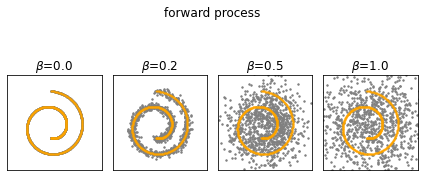

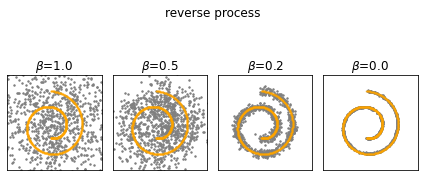

In [51]:
# compare the above sequential sampling process against the iid sampling process

# ------------------------------ forward process ----------------------------- #
temps = [0, 20, 50, 100]
fig, ax = plt.subplots(1, len(temps), figsize=(6, 3))
from rad_utils import diffused_sample
idx = 0
for t in temps:
    if t == 0:
        x_t = data_2d
    else:
        x_t = diffused_sample(100, t-1, data_2d)
    ax[idx].scatter(*x_t[:].T, s=2, color='grey')
    ax[idx].scatter(*data_2d.T, color='orange', alpha=0.4, s=1, label="initial points")
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    ax[idx].set_title(f'$\\beta$={t/100}')
    remove_all_ticks_and_labels(ax[idx])
    idx += 1
fig.suptitle('forward process')
fig.tight_layout()

save = True
if save==True:
    savedir = 'plots/neurips'
    figname = f'vanilla_forward_process.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

# ------------------------------ reverse process ----------------------------- #
x_ad = p_sample_loop(model, data_2d.shape, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
temps = [100-t for t in temps]
fig, ax = plt.subplots(1, len(temps), figsize=(6, 3))
idx = 0
for t in reversed(temps):
    ax[idx].scatter(*x_ad[t].T, s=2, color='grey')
    ax[idx].scatter(*data_2d.T, color='orange', alpha=0.4, s=1, label="initial points")
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    ax[idx].set_title(f'$\\beta$={(100-t)/100}')
    remove_all_ticks_and_labels(ax[idx])
    idx += 1
fig.suptitle('reverse process')
fig.tight_layout()

save = True
if save==True:
    savedir = 'plots/neurips'
    figname = f'vanilla_reverse_process.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

# many iterations of AD -> RAD -> AD for the entire manifold

size of the training set is 1000


100%|██████████| 99/99 [04:20<00:00,  2.64s/it]


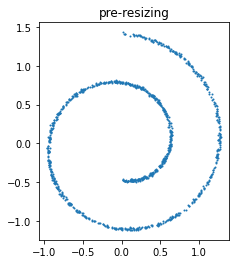

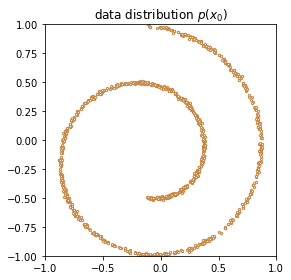

In [15]:
from rad_utils import rad_ad_cycle

# go through the rad-ad cycle multiple times
num_samples = 1000
data_2d = load_unimodal_data(num_samples, manifold_type='swiss_roll')
num_iters = 100

xf_ad = rad_ad_cycle(data_2d, model, num_steps, alphas, betas, one_minus_alphas_prod_sqrt)
xfs_roll2d = [xf_ad]
for i in trange(num_iters-1):
    # xf_ad = rad_ad_cycle(xf_ad)
    xf_ad = rad_ad_cycle(xf_ad, model, num_steps, alphas, betas, one_minus_alphas_prod_sqrt)
    xfs_roll2d.append(xf_ad)
xfs_roll2d = torch.stack(xfs_roll2d).detach().numpy()

In [18]:
from likelihood_utils import save_or_load_to_zarr
# save_or_load_to_zarr('save', name='xfs_roll2d', data=xfs_roll2d)
xfs_roll2d = save_or_load_to_zarr('load', name='xfs_roll2d')
xfs_roll2d = torch.from_numpy(xfs_roll2d)

saved!


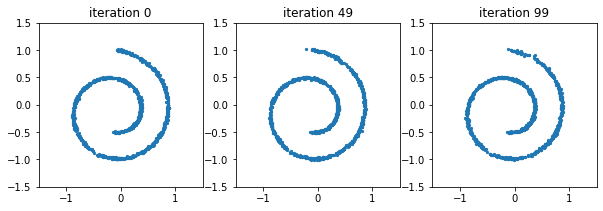

In [19]:
# plot the manifold over different iterations
fig, ax = plt.subplots(1, 3, figsize=(10,5))

ax_idx = 0
for idx, xf in enumerate(xfs_roll2d):
    if idx in [0, 49, 99]:
        ax[ax_idx].scatter(*xf.T, s=5)
        ax[ax_idx].set(title=f'iteration {idx}')
        ax[ax_idx].set(xlim=lims, ylim=lims)
        ax[ax_idx].set_aspect('equal')
        ax_idx += 1



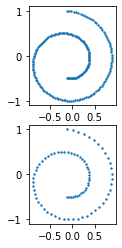

In [20]:
def rescaled_sr(num_samples):
    t = 1.5 * np.pi * (1 + 2 * np.linspace(0, 1, num_samples))
    x = ((t * np.cos(t) / 10 -min) / (max - min)) * 2 -1
    y = ((t * np.sin(t) / 10 -min) / (max - min)) * 2 -1
    return t, x, y

t2, x2, y2 = rescaled_sr(80)

fig, ax = plt.subplots(2, 1)
ax[0].scatter(x, y, s=2)
ax[1].scatter(x2, y2, s=2)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# X += noise * generator.randn(2, n_samples)  # so the way they add noise is to get each sample from the manifold and add a bit of gaussian noise to it


## The projection method

[Text(0.5, 1.0, 'histogram of points on manifold')]

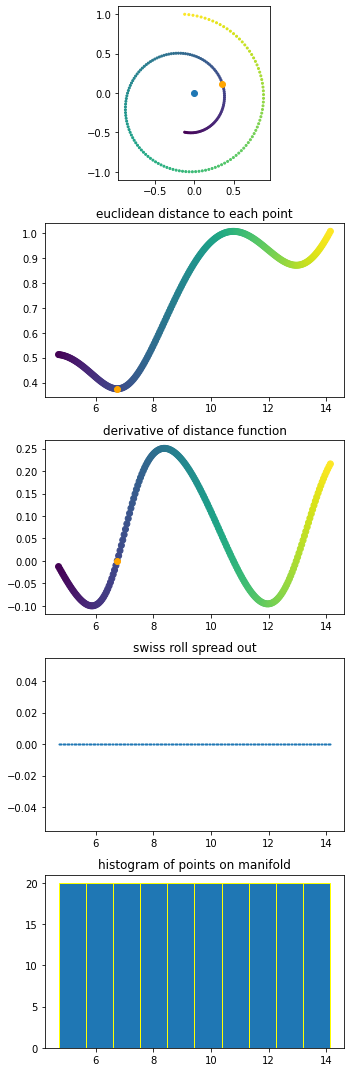

In [21]:
from rad_utils import generate_2d_swiss_roll
num_points = 200
t, clean_manifold, min, max = generate_2d_swiss_roll(num_points, True)
x, y = clean_manifold[:, 0], clean_manifold[:, 1]

x1, y1 = 0, 0

derv_unscaled = 2 * (t*np.cos(t)/10 - x1) * (np.cos(t)/10 - t * np.sin(t) / 10) + 2 * (t * np.sin(t)/10 - y1) * (np.sin(t)/10 + t * np.cos(t)/10)
derv = (4*(np.cos(t)/10 - 1/10 *t*np.sin(t))*(-x1 + (2*(1/10 * t*np.cos(t) - min))/(max - min) - 1))/(max - min) + (4*(np.sin(t)/10 + 1/10 *t*np.cos(t))*(-y1 + (2*(1/10 *t*np.sin(t) - min))/(max - min) - 1))/(max - min)
dist_unscaled = np.sqrt(((t * np.cos(t))/10 - x1)**2 + ((t * np.sin(t))/10 - y1)**2)
dist = np.sqrt(((2*(1/10 *t*np.cos(t) - min))/(max - min) - 1 - x1)**2 + ((2*(1/10 *t*np.sin(t) - min))/(max - min) - 1 - y1)**2)

eq2 = derv / (2 * dist)

cmap = plt.cm.viridis
colors = cmap(np.linspace(0,1,num_points))

fig, ax = plt.subplots(5, 1, figsize=(5, 15))
ax[0].scatter(x, y, s=4, c=colors)
ax[0].set_aspect('equal')
ax[0].scatter(x1, y1)
ax[1].scatter(t, dist, c=colors)
ax[1].set(title='euclidean distance to each point')
ax[2].scatter(t, eq2, c=colors)
ax[2].set(title='derivative of distance function')
fig.tight_layout()

# identify the point closest to 0:
min_val = np.min(dist)
min_index = np.argmin(dist)
ax[0].scatter(x[min_index], y[min_index], c='orange')
ax[1].scatter(t[min_index], dist[min_index], c='orange')
ax[2].scatter(t[min_index], eq2[min_index], c='orange')

# produce histogram of points on the manifold
ax[3].scatter(t, np.zeros(num_points), s=1)
ax[3].set(title='swiss roll spread out')

ax[4].hist(t, bins=10, ec="yellow")
ax[4].set(title='histogram of points on manifold')

## sanity checks

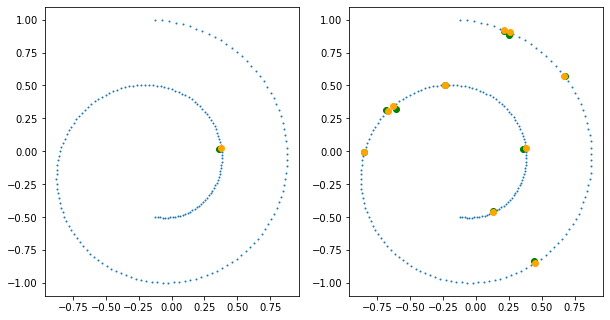

In [22]:
num_points = 5000
t, clean_manifold, min, max = generate_2d_swiss_roll(num_points, True)

# original non-noisy manifold (ground truth with no randomness)
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].scatter(x, y, s=1)
ax[0].set_aspect('equal')

# "stick" the noisy data to the closest point on the clean manifold
# projection method is now in rad_utils:
from rad_utils import project_onto_clean_2d_roll_manifold
 
noisy_manifold_points = xfs_roll2d[0][0:10, :]
# noisy_manifold_point = xfs_roll2d[0][0, :]

nearest_points, _ = project_onto_clean_2d_roll_manifold(noisy_manifold_points, clean_manifold, min, max, t)

ax[0].scatter(*xfs_roll2d[0][0, :], c='green')
ax[0].scatter(*nearest_points[0], c='orange')

ax[1].scatter(x, y, s=1)
ax[1].scatter(noisy_manifold_points[:,0], noisy_manifold_points[:, 1], c='green')
ax[1].scatter(nearest_points[:, 0], nearest_points[:, 1], c='orange')
ax[1].set_aspect('equal')


## now doing this for noisy diffusion manifolds

In [14]:
# first do the training dataset (this manifold still has some randomness in it -- it's not totally uniform)
from rad_utils import project_onto_clean_2d_roll_manifold
training_manifold = data_2d 
nearest_pts, pts_t = project_onto_clean_2d_roll_manifold(training_manifold, clean_manifold, t)

# now for the entire manifold
noisy_manifold_0 = xfs_roll2d[0]
noisy_manifold_1 = xfs_roll2d[49]
noisy_manifold_2 = xfs_roll2d[99]
nearest_pts_0, pts_t_0 = project_onto_clean_2d_roll_manifold(noisy_manifold_0, clean_manifold, t)
nearest_pts_1, pts_t_1 = project_onto_clean_2d_roll_manifold(noisy_manifold_1, clean_manifold, t)
nearest_pts_2, pts_t_2 = project_onto_clean_2d_roll_manifold(noisy_manifold_2, clean_manifold, t)

pts_ts = [pts_t, pts_t_0, pts_t_1, pts_t_2]

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].scatter(*nearest_pts.T, s=2)
ax[0].set(title='training dataset')
ax[1].scatter(*nearest_pts_0.T, s=2)
ax[1].set(title='cycle 1')
ax[2].scatter(*nearest_pts_1.T, s=2)
ax[2].set(title='cycle 50')
ax[3].scatter(*nearest_pts_2.T, s=2)
ax[3].set(title='cycle 100')
for a in ax:
    a.set_aspect('equal')

# produce histogram of points, as a function of t...
fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
fig.suptitle('histogram of points on manifold')
ax[0].hist(pts_t, bins=5, ec="yellow")
ax[1].hist(pts_t_0, bins=5, ec="yellow")
ax[2].hist(pts_t_1, bins=5, ec="yellow")
ax[3].hist(pts_t_2, bins=5, ec="yellow")
ax[0].set(ylabel="number of points", xlabel="position along spiral")


# ---------------- comparison of empirical and reference cdfs ---------------- #
from scipy.stats import kstest

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
fig.suptitle('comparison of empirical and reference cdfs')

# reference cdf
reference_dist_cdf = stats.uniform.cdf(t[::5], loc=1.5 * np.pi, scale=3 * np.pi)

# plotting the empirical cdf against the reference cdf
for i in range(4):
    # reference cdf
    ax[i].plot(t[::5], reference_dist_cdf)
    
    # empirical samples
    empirical_samples = pts_ts[i][:, 0] 
    
    # turn empirical samples into cdf
    x = np.sort(empirical_samples)
    y = np.arange(len(x))/float(len(x))
    ax[i].plot(x, y)
    ax[i].set(xlabel='t')

    print(kstest(rvs=empirical_samples, cdf=reference_dist_cdf))

TypeError: project_onto_clean_2d_roll_manifold() missing 2 required positional arguments: 'max' and 'clean_manifold_t'

## how does the distribution change as a function of cycle?

In [39]:
# nearest_points = []
t_points = []
hists = []
for i in range(100):
    noisy_manifold = xfs_roll2d[i]
    _, pts_t = project_onto_clean_line_manifold(noisy_manifold, clean_manifold, t)
    hist, bins = np.histogram(pts_t, bins=5)
    
    # nearest_points.append(nearest_pts)
    t_points.append(pts_t)
    hists.append(hist)
t_points = np.vstack(t_points)
hists = np.vstack(hists)

print(hists.shape)

(100, 5)


[(0.0, 250.0)]

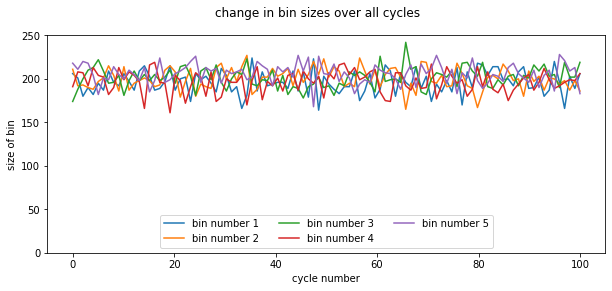

In [41]:
# plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for j in range(5):
    ax.plot(np.linspace(0, 100, 100), hists[:, j], label=f"bin number {j+1}")
fig.suptitle('change in bin sizes over all cycles')
ax.set(xlabel='cycle number', ylabel='size of bin')
ax.legend(loc='lower center', ncol=3)
ax.set(ylim=[0, 250])

# line manifold
## how much of this is because of the spherical shape of the manifold?

first we'll try with a 2D line manifold, and then with the 3D swiss roll embedded in a 10D space. Which we'll analyze not parametrically, but using the 1D method that Cristina mentioned. 

embedding dimension is 2
manifold dimension is 1
model loaded!
the model has 133634 parameters
size of the training set is 1000


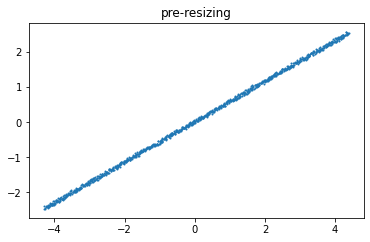

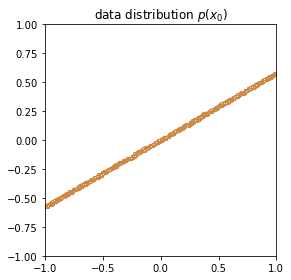

In [59]:
# 3D manifold embedded in the 10D embedding space
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #
model_line, num_steps_line, embedding_dims_line = select_model('unconditional-concat', 12)

# data
data_line = load_unimodal_data(num_samples, manifold_type='line')


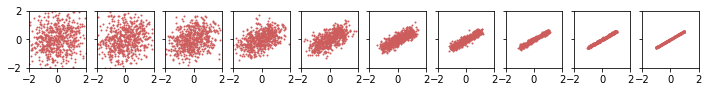

In [60]:
# ------------------- plot samples from the reverse process ------------------ #
from rad_utils import plot_reverse_samples_10_steps
sample_size = 500

alphas, betas, one_minus_alphas_prod_sqrt, x_seq = plot_reverse_samples_10_steps(model_line, num_samples, embedding_dims_line, num_steps_line)


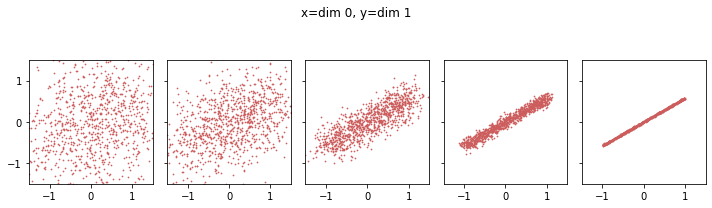

In [61]:
from rad_utils import prior_sampling
prior_sampling(num_steps_line, model_line, embedding_dims_line, dim1=0, dim2=1)

## One cycle of the RAD/AD cycle for the line manifold

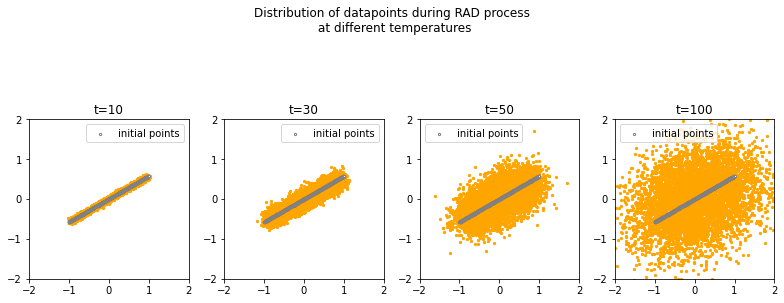

In [62]:
from rad_utils import rad_ad_various_temps

rad_ad_various_temps(data_line, model_line, alphas, betas, one_minus_alphas_prod_sqrt)

so at the largest value of t=T, it doesn't look like a isotropic Gaussian -- there's a correlation structure... so does this amplify over the course of the many rad/ad cycles?   

## RAD/AD cycle for line manifold

In [63]:
from rad_utils import rad_ad_cycle

# go through the rad-ad cycle multiple times
num_samples = 1000
num_iters = 100

xf_ad = rad_ad_cycle(data_line, model_line, num_steps, alphas, betas, one_minus_alphas_prod_sqrt)
xfs_line = [xf_ad]
# for i in range(num_iters-1):
for i in trange(num_iters-1, desc='rad + ad', unit='cycles'):
    xf_ad = rad_ad_cycle(xf_ad, model_line, num_steps_line, alphas, betas, one_minus_alphas_prod_sqrt)
    xfs_line.append(xf_ad)
xfs_line = torch.stack(xfs_line)

rad + ad: 100%|██████████| 99/99 [01:18<00:00,  1.26cycles/s]


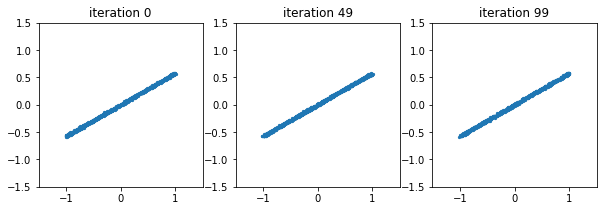

In [64]:
# plot the manifold over different iterations
fig, ax = plt.subplots(1, 3, figsize=(10,5))

ax_idx = 0
for idx, xf in enumerate(xfs_line):
    if idx in [0, 49, 99]:
        ax[ax_idx].scatter(*xf.T, s=5)
        ax[ax_idx].set(title=f'iteration {idx}')
        ax[ax_idx].set(xlim=lims, ylim=lims)
        ax[ax_idx].set_aspect('equal')
        ax_idx += 1

### plotting the distribution on the line
we should expect, based on the correlation structure of the fully diffused part of the cycle, that we should see more points in the middle of the line. 

we need to:
1. map the noisy manifold onto the clean manifold, parameterized as position along the line
2. then calculate the distribution along that line using a histogram

(1000, 2)


[Text(0.5, 1.0, 'anti-diffused results')]

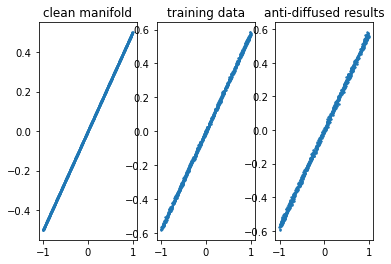

In [65]:
# mapping the points onto the clean line requires a parameterized line. 
# the equation for this is y = 0.5x for x = [-1, 1]
x = np.linspace(-1, 1, 1000)
y = 0.5 * x
clean_manifold = np.vstack((x, y)).T

print(clean_manifold.shape)

fig, ax = plt.subplots(1,3)
ax[0].scatter(*clean_manifold.T, s=2)
ax[0].set(title='clean manifold')
ax[1].scatter(*data_line.T, s=2)
ax[1].set(title='training data')
ax[2].scatter(*xfs_line[0].T, s=2)
ax[2].set(title='anti-diffused results')


In [66]:
# we need to map the noisy points to the closest point on the clean manifold
from rad_utils import project_onto_clean_line_manifold

t = np.linspace(-1, 1, 1000)
manifold_pts_xy, manifold_pts_t = project_onto_clean_line_manifold(xfs_line[0], clean_manifold, t)

[Text(0, 0.5, 'number of points'), Text(0.5, 0, 'position along spiral')]

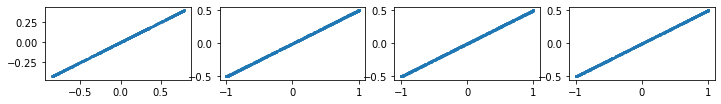

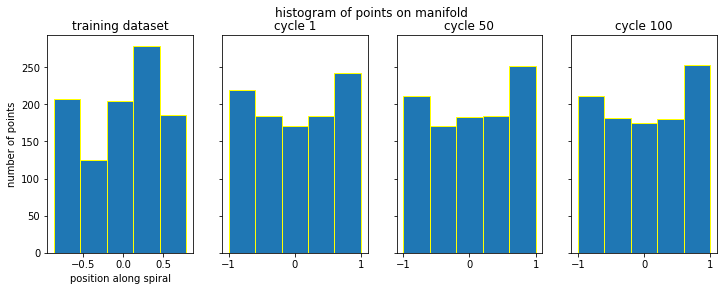

In [67]:
# first do the training dataset (this manifold still has some randomness in it -- it's not totally uniform)
from rad_utils import project_onto_clean_line_manifold
training_manifold = data_2d
nearest_pts, pts_t = project_onto_clean_line_manifold(training_manifold, clean_manifold, t)

# now for the entire manifold
noisy_manifold_0 = xfs_line[0]
noisy_manifold_1 = xfs_line[49]
noisy_manifold_2 = xfs_line[99]
nearest_pts_0, pts_t_0 = project_onto_clean_line_manifold(noisy_manifold_0, clean_manifold, t)
nearest_pts_1, pts_t_1 = project_onto_clean_line_manifold(noisy_manifold_1, clean_manifold, t)
nearest_pts_2, pts_t_2 = project_onto_clean_line_manifold(noisy_manifold_2, clean_manifold, t)

all_nearest_points_line = [nearest_pts, nearest_pts_0, nearest_pts_1, nearest_pts_2]

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].scatter(*nearest_pts.T, s=2)
ax[1].scatter(*nearest_pts_0.T, s=2)
ax[2].scatter(*nearest_pts_1.T, s=2)
ax[3].scatter(*nearest_pts_2.T, s=2)
for a in ax:
    a.set_aspect('equal')

# produce histogram of points, as a function of t...
fig, ax = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
fig.suptitle('histogram of points on manifold')
ax[0].hist(pts_t, bins=5, ec="yellow")
ax[0].set(title='training dataset')
ax[1].hist(pts_t_0, bins=5, ec="yellow")
ax[1].set(title='cycle 1')
ax[2].hist(pts_t_1, bins=5, ec="yellow")
ax[2].set(title='cycle 50')
ax[3].hist(pts_t_2, bins=5, ec="yellow")
ax[3].set(title='cycle 100')
ax[0].set(ylabel="number of points", xlabel="position along spiral")